In [1]:
import numpy as np
import math
import sounddevice
import soundfile as sf
import matplotlib.pyplot as plt
from scipy import signal
from Audio_data import Audio_data
from Matrix_array import Matrix_array
from Audio_source import Audio_source
from Color_map import Color_map
from pathlib import Path

import config

# GLOBAL VARIABLES
c = 340                     # propagation speed of sound

In [2]:
def antenna_setup():
    r_a1 = config.r_a1      # coordinate position of origin of array1
    r_a2 = config.r_a2      # coordinate position of origin of array2
    r_a3 = config.r_a3      # coordinate position of origin of array3
    r_a4 = config.r_a4      # coordinate position of origin of array4
    uni_distance = config.distance
    row_elements = config.rows
    column_elements = config.columns

    # array_matrix_1, array_matrix_2, array_matrix_3, array_matrix_4 below can be generated in parallell
    array_matrix_1 = Matrix_array(r_a1,uni_distance,row_elements,column_elements)
    array_matrix_2 = Matrix_array(r_a2,uni_distance,row_elements,column_elements)
    array_matrix_3 = Matrix_array(r_a3,uni_distance,row_elements,column_elements)
    array_matrix_4 = Matrix_array(r_a4,uni_distance,row_elements,column_elements)
    array_list = [array_matrix_1, array_matrix_2, array_matrix_3, array_matrix_4]

    # array_matrices contains the current active arrays that should be used 
    #  (number of arrays defined by config.matrices)
    array_matrices = np.array(array_list[:config.active_arrays], dtype=object)
    
    # array_matrices = np.array([array_matrix_1, array_matrix_2, array_matrix_3, array_matrix_4], dtype=object)

    sub_arrays = len(array_matrices)

    for array in range(sub_arrays):
        plt.title('Array setup')
        plt.scatter(array_matrices[array].get_r_prime()[0,:], array_matrices[array].get_r_prime()[1,:])
        
    return array_matrices

In [3]:
def generate_array_signals(matrix_array, sources, t):
    r_prime = matrix_array.get_r_prime()
    Audio_signal = np.zeros((len(t), len(r_prime[0,:])))

    for sample in range(len(t)):
        if (sample+1 in np.linspace(0,len(t),10)) or (sample == 0): # print stuff so user know how many samples that have been generated
            print(sample+1)                                         # print stuff so user know how many samples that have been generated
        for mic in range(len(r_prime[0,:])):
            x_i = r_prime[0,mic]
            y_i = r_prime[1,mic]
            temp_signal_sample = 0
            for source in range(len(sources)):
                if (sources[source].get_t_start() < t[sample]) and (t[sample] < sources[source].get_t_end()):
                    frequencies_ps = sources[source].get_frequency()
                    theta_source = sources[source].get_theta()
                    phi_source = sources[source].get_phi()
                    rho_soruce = sources[source].get_rho()
                    for freq_ind in range(len(frequencies_ps)):
                        k = 2*math.pi*frequencies_ps[freq_ind]/c
                        r_1 = np.array([x_i,y_i,0])
                        r_2 = rho_soruce * r_vec(theta_source,phi_source)
                        norm_coeff = np.linalg.norm(r_2-r_1)
                        phase_offset = -k*norm_coeff
                        element_amplitude = 1/norm_coeff
                        temp_signal_sample += element_amplitude * math.sin(2*math.pi* frequencies_ps[freq_ind] * t[sample] + phase_offset)
            Audio_signal[sample,mic] = temp_signal_sample
    return Audio_signal

In [4]:
def r_vec(theta,phi):
    r = np.array([(math.sin(theta)*math.cos(phi)), math.sin(theta)*math.sin(phi), math.cos(theta)])
    return r

In [5]:
def filtering(array_audio_signals, sub_arrays, frequency_bands, f_sampling, elements):
    audio_filtered_complete = np.zeros((sub_arrays, len(frequency_bands)), dtype=object)
    filter_order = config.filter_order              # filter order
    scale_factor = config.scale_factor              # scale factor, making filter bandwidth more narrow

    for array in range(sub_arrays):
        Audio_signal = array_audio_signals[array].get_audio_signals()
        calibration_weights = load_calibration_weights(array, elements, len(frequency_bands))
        for freq_ind in range(len(frequency_bands)):
            # filter design for each band
            nu_0 = 2*frequency_bands[freq_ind]/f_sampling   # normalized frequency                        # scale factor, making filter bandwidth more narrow
            cut_off = [nu_0 - nu_0/scale_factor, nu_0 + nu_0/scale_factor]
            b = signal.firwin(filter_order, cut_off, window="hamming", pass_zero=False) # filter coefficients
            audio_temp = np.zeros((len(Audio_signal[:,0]),elements))
            for mic_ind in range(elements):
                # apply filter on every signal recorded from the elements
                audio_temp[:,mic_ind] = calibration_weights[freq_ind,mic_ind] * signal.lfilter(b, 1.0, Audio_signal[:,mic_ind])

            audio_filtered_complete[array,freq_ind] = Audio_data(audio_temp)

            # plot all filters
            plt.figure(2)
            w, h = signal.freqz(b, worN=8000)
            H = 20*np.log10(abs(h))
            plt.plot((w/math.pi)*f_sampling/2, 20*np.log10(abs(h)), linewidth=2)
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Gain (dB)')
            plt.title('Frequency Response of all filters')
            plt.ylim(-5, 0.5)
            plt.xlim(70, f_sampling/2)
            plt.grid(True)
    print('Filtering of signals completed.')
    return audio_filtered_complete

In [6]:
def load_calibration_weights(array, elements, f_bands):
    # placeholder function, to be completed later
    # function should load calibration weights form file
    # returns matrix with calibration weightsfor all microphones, at all calibration frequencies
    weights = np.ones((f_bands,elements))
    #hamming_array = np.blackman(config.rows)
    #for i in range(3):
    #    hamming_array = np.append(hamming_array, hamming_array)
    #weights[35:45,] = np.multiply(weights[35:45,], np.transpose(hamming_array))
    return weights

In [7]:
def scanning(y_listen, x_listen, r_scan, frequency_bands, audio_filtered_complete, array_matrices, f_sampling, sub_arrays):
    # Start scanning
    color_maps_complete = np.zeros(len(frequency_bands), dtype=object)
    for freq_ind in range(len(frequency_bands)):
        color_map_new = np.zeros((len(y_listen),len(x_listen)))
        color_maps_complete[freq_ind] = Color_map(color_map_new)
    for x_ind in range(len(x_listen)):
        print('\n x_ind: '+str(x_ind+1))                # print stuff for user
        x = x_listen[x_ind]                             # current x-coordinate
        print('\t y_ind:', end=' ')                     # print stuff for user
        for y_ind in range(len(y_listen)):
            print(str(y_ind+1), end=' ')                # print stuff for user
            y = y_listen[y_ind]                         # current x-coordinate
            z_0 = math.sqrt(r_scan**2 - x**2 - y**2)
            theta = math.acos(z_0/r_scan)               # get theta from our x,y coordinates
            phi = math.atan2(y,x)                       # get phi from our x,y coordinates
            for freq_ind in range(len(frequency_bands)):
                # apply beamforming algo. in every frequency band 
                #mic_data = beam(audio_filtered_complete, array_matrices, theta, phi, frequency_bands[freq_ind], freq_ind, f_sampling)
                mic_data = beam_forming_algorithm(audio_filtered_complete, array_matrices, theta, phi, frequency_bands[freq_ind], freq_ind, f_sampling)
                
                # obtain relative power in the listening direction
                color = sum(abs(mic_data)**2)

                # relative power inte the direction [theta, phi] saved in matrix
                color_maps_complete[freq_ind].set_color(y_ind, x_ind, color)
    return color_maps_complete

In [8]:
def listening(audio_filtered_complete, array_matrices, theta_listen, phi_listen, frequency_bands, f_sampling, samples):
    audio_out = np.zeros((samples))
    theta_rad = theta_listen*math.pi/180    # listening angle in radians
    phi_rad = phi_listen*math.pi/180        # listening angle in radians
    for freq_ind in range(len(frequency_bands)):
        print(freq_ind, end=' ')
        mic_signal = beam_forming_algorithm(audio_filtered_complete,array_matrices, theta_rad, phi_rad, frequency_bands[freq_ind], freq_ind, f_sampling)
        # MISO, summation of all mic_signals to one
        audio_out += mic_signal[0]
    # scale audio signal
    audio_out = audio_out/max(audio_out)
    return audio_out

In [9]:
def listening_improved(array_audio_signals, array_matrices, theta, phi, adaptive_weight_matrix, calibration_weights, filter_coefficients, frequency_bands, f_sampling, samples, sub_arrays):
    x_factor = math.sin(theta) * math.cos(phi)
    y_factor = math.sin(theta) * math.sin(phi)
    audio_out = np.zeros((samples,1))

    for array in range(sub_arrays):
        #print('array: '+str(array+1))               # print for user
        r_prime = array_matrices[array].get_r_prime()
        audio_signals = array_audio_signals[array].get_audio_signals()
    
        elements = config.rows*config.columns
        print('freq_ind: ', end=' ')
        for freq_ind in range(len(filter_coefficients[:,0])):
            print(str(freq_ind+1), end=' ')  # print for user
            b = filter_coefficients[freq_ind,:]     # filter coefficient for the current band
            frequency = frequency_bands[freq_ind]   # center frequency
            k = 2*math.pi*frequency/c               # the narrowband frequency
            ny = frequency/f_sampling               # normalized frequency
            weights = adaptive_weight_matrix[weight_index(frequency)-1,:]

            audio_temp = np.zeros((samples,1))
            mic_data = np.zeros((samples,1))

            for mic_ind in range(elements):
                if weights[mic_ind] == 1:
                    audio_temp[:,0] = calibration_weights[freq_ind,mic_ind] * signal.lfilter(b, 1.0, audio_signals[:,mic_ind])
                    phase_shift_value = -k*(r_prime[0,mic_ind] * x_factor + r_prime[1,mic_ind]*y_factor)

                    #   Sum the individually shifted data from the atnenna elements as well as weight them with
                    #   appropriate weight.
                    mic_data += weights[mic_ind] * phase_shift(audio_temp,ny,phase_shift_value)

            norm_coeff = 1/sum(weights)
            audio_out += mic_data * norm_coeff
    return audio_out



In [10]:
def beam_forming_algorithm(audio_filtered_complete, array_matrices, theta, phi, frequency, freq_ind, f_sampling):
    #samples = len(audio_filtered_complete[0, 0].get_audio_signals()[:,0])  # amount of samples of the audio tracks #################### ORIGINAL ####################
    samples = len(audio_filtered_complete[0, 0].get_audio_signals()[200:,0])
    array_data = np.zeros((samples,1))

    for array in range(len(array_matrices)):
        # Use the filtered audio signals
        
        #audio_temp_signals = audio_filtered_complete[array, freq_ind].get_audio_signals() #################### ORIGINAL ####################
        audio_temp_signals = audio_filtered_complete[array, freq_ind].get_audio_signals()[200:,]

        #   The r_prime vector of the matrix array to know the location of every element, as well as how many 
        #   elements exists.
        r_prime = array_matrices[array].get_r_prime()
        elements = array_matrices[array].get_elements()

        #   The narrowband wavevnumber
        k = 2*math.pi*frequency/c

        #   The normalized frequency
        ny = frequency/f_sampling

        #   Initialize output vector
        mic_data = np.zeros((samples,1))

        #   The compensation factors to obtain uniform phase in the direction r_hat(theta,phi)
        x_factor = math.sin(theta)*math.cos(phi)
        y_factor = math.sin(theta)*math.sin(phi)
                # Adaptive configuration of the antanna array
        
        adaptive_weight = adaptive_array_config(array_matrices[array], frequency)

        for mic_ind in range(elements):
            #   calculate the narrowband phase-shift
            phase_shift_value = -k*(r_prime[0,mic_ind] * x_factor + r_prime[1,mic_ind]*y_factor)

            #   Sum the individually shifted data from the atnenna elements as well as weight them with
            #   appropriate weight.
            mic_data = mic_data + adaptive_weight[0,mic_ind] * phase_shift(audio_temp_signals[:,mic_ind],ny,phase_shift_value)

        norm_coeff = 1/sum(adaptive_weight[0])
        mic_data = mic_data * norm_coeff

        # Perform the beamforming algoritm (phase-shift input signal according to listening direction)
        array_data += mic_data

    return array_data

In [11]:
def adaptive_array_config(matrix_array, frequency):
    # Adaptive configuration of the antanna array
    # Selects only necessary antenna-elements to maintain small beamwidth

    row_elements = matrix_array.get_row_elements()
    column_elements = matrix_array.get_row_elements()
    uni_distance = matrix_array.get_uni_distance()
    
    wavelength = c/frequency                    # wavelength of signal
    wavelength_rel = uni_distance/wavelength    # relative wavelenght to distance between microphone elements

    if wavelength_rel>0.1581:
        # mode 1
        weight = np.ones((1, row_elements*column_elements))
        return weight
    elif (wavelength_rel <= 0.156) and (wavelength_rel > 0.0986):
        mode = 3
    elif (wavelength_rel <= 0.0986) and (wavelength_rel > 0.085):
        mode = 5
    elif (wavelength_rel <= 0.085) and (wavelength_rel > 0.07):
        mode = 6
    else:
        mode = 7

    weight = np.zeros((1,row_elements*column_elements))
    row_lim = math.ceil(row_elements/mode)
    column_lim = math.ceil(column_elements/mode)

    for i in range(row_lim):
        for j in range(column_lim):
            element_index = (mode*i*row_elements + mode*j) # this calculation could be wrong thanks to matlab and python index :))
            weight[0,element_index] = 1
    return weight

In [12]:
def adaptive_array_config_matrix(matrix_array):
    # Creates the weight matrix
    row_elements = matrix_array.get_row_elements()
    column_elements = matrix_array.get_row_elements()

    weight_matrix = np.zeros((7, row_elements*column_elements))


    for mode in range(1,config.modes+1):
        weight = np.zeros((1,row_elements*column_elements))
        row_lim = math.ceil(row_elements/mode)
        column_lim = math.ceil(column_elements/mode)
        for i in range(row_lim):
            for j in range(column_lim):
                element_index = (mode*i*row_elements + mode*j) # this calculation could be wrong thanks to matlab and python index :))
                weight[0,element_index] = 1
        weight_matrix[mode-1,:] = weight
    return weight_matrix

In [13]:
def weight_index(frequency):
    # calculates what mode to use, depending on the wavelength of the signal
    uni_distance = config.distance              # distance between elements
    wavelength_rel = frequency*uni_distance/c    # relative wavelength to distance between microphone elements

    if wavelength_rel>0.1581:
        mode = 1
    elif (wavelength_rel <= 0.156) and (wavelength_rel > 0.0986):
        mode = 3
    elif (wavelength_rel <= 0.0986) and (wavelength_rel > 0.085):
        mode = 5
    elif (wavelength_rel <= 0.085) and (wavelength_rel > 0.07):
        mode = 6
    else:
        mode = 7
    return mode

In [14]:
def phase_shift(x,ny,phase):
    #   Input signal x
    #
    #   Output signal y
    #
    #   if x = cos(n*2*pi*ny), then y = cos(n*2*pi*ny + phase)
    #
    x_length = len(x)
    y = np.zeros((x_length,1))

    for i in range(x_length-1):
        y[i] = math.cos(phase) * x[i] + math.sin(phase)/(2*math.pi*ny)*(x[i+1]/2 - x[i-1]/2)
        #y[i] = math.cos(phase) * x[i] + math.sin(phase)/(2*math.pi*ny)*(x[i+1])
    return y

In [15]:
def extents(f):
    # function to show images with correct grid values (with plt.imshow()), corresponding to our scanning window
    delta = f[1]-f[0]
    return [f[0] - delta/2, f[-1] + delta/2]

In [16]:
def validation_check(y_listen, x_listen, sources, r_scan):
    # Validation check
    xy_val_check = np.zeros((len(y_listen),len(x_listen)))

    for x_ind in range(len(x_listen)):
        x = x_listen[x_ind]
        for y_ind in range(len(y_listen)):
            y = y_listen[y_ind]
            temp_val = 0
            for source_ind in range(len(sources)):
                x_s = r_scan * math.sin(sources[source_ind].get_theta()) * math.cos(sources[source_ind].get_phi())
                y_s = r_scan * math.sin(sources[source_ind].get_theta()) * math.sin(sources[source_ind].get_phi())
                temp_val += 1/math.sqrt(((x_s -x)**2 + (y_s - y)**2))
            xy_val_check[y_ind, x_ind] = temp_val

    plt.figure(3)
    plt.imshow(xy_val_check, extent= extents(x_listen) + extents(y_listen), origin='lower')
    plt.title('Actual location of sources')

In [17]:
def show_beamforming_results(y_listen, x_listen, color_maps):
    color_map_intensity = np.zeros((len(y_listen), len(x_listen)))
    for freq_ind in range(len(frequency_bands)):
        color_map_intensity += color_maps[freq_ind].get_color_data_matrix() ####################### ORIGINAL ###########################
        #color_map_intensity += color_maps[freq_ind].get_color_data_matrix() / (frequency_bands[freq_ind])
    plt.figure(4)
    plt.imshow(color_map_intensity, extent= extents(x_listen) + extents(y_listen), origin='lower')
    plt.title('Beamforming results')
    return color_map_intensity

In [18]:
def maximum_intensity(color_maps_complete, frequency_bands):
    # Get maximum intensity of a signals, at any frequency
    max_intensity = 0
    for freq_ind in range(len(frequency_bands)):
        intensity = np.max(np.max(color_maps_complete[freq_ind].get_color_data_matrix()))
        if intensity > max_intensity:
            max_intensity = intensity
    return max_intensity

In [19]:
def calculate_filter_coefficients(f_sampling, frequency_bands):
    scale_factor = config.scale_factor
    f_bands_N = config.f_bands_N
    filter_order = config.filter_order
    f_coefficients = np.zeros((f_bands_N, filter_order))
    for freq_ind in range(config.f_bands_N):
        nu_0 = 2*frequency_bands[freq_ind]/f_sampling
        cut_off = [nu_0 - nu_0/scale_factor, nu_0 + nu_0/scale_factor]
        b = signal.firwin(filter_order, cut_off, window="hamming", pass_zero=False) # filter coefficients
        f_coefficients[freq_ind,:] = b
    return f_coefficients

In [20]:
def load_data(filename):
    initial = config.initial_values
    # Load recorded data from file
    path = Path(config.path + filename + '.txt')
    data = np.loadtxt(open(path,'rb'),delimiter=',')
    # Get sampling frequency
    f_sampling = data[0,0]

    # take out only the values of the microphones (column 2:66)
    # and data after the initial startup (rows initial:end)
    #data = data[initial:,2:66]
    data = data[initial:initial+300, 2:66]
    return Audio_data(data), int(f_sampling)


In [ ]:
def load_data_FPGA(filename):
    initial = config.initial_values
    # Load recorded data from file
    path = Path(config.path + filename + '.txt')
    data = np.loadtxt(open(path,'rb'),delimiter=',')
    # Get sampling frequency
    f_sampling = 15625

    # take out only the values of the microphones (column 2:66)
    # and data after the initial startup (rows initial:end)
    #data = data[initial:,2:66]
    data = data[initial:initial+300,]
    return Audio_data(data), int(f_sampling)

In [21]:
def play_sound(sound_signal, f_sampling):

    sounddevice.play(sound_signal, f_sampling, blocking=True)

    sf.write("test.wav", sound_signal, int(f_sampling), 'PCM_24')


In [22]:
def generate_filename():
    if config.sources == 1:
        filename ='emul_'+str(config.f_start1)+'Hz_'+'theta='+str(config.theta_deg1)+'_phi='+str(config.phi_deg1)+ \
            '_samples='+str(config.samples)+'_A'+str(config.active_arrays)
    elif config.sources == 2:
        filename ='emul_'+str(config.f_start1)+str(config.f_start2)+'Hz_'+'theta='+str(config.theta_deg1)+str(config.theta_deg2)+ \
        '_phi='+str(config.phi_deg1)+str(config.phi_deg2)+'_samples='+str(config.samples)+'_A'+str(config.active_arrays)
    return filename

In [23]:
def scanning_not_improved(array_audio_signals, array_matrices, x_listen, y_listen, r_scan, 
adaptive_weight_matrix, calibration_weights, filter_coefficients, frequency_bands, f_sampling, samples, sub_arrays):
    # not really improved in time, since the filtering takes longer
    # Create empty color_maps
    color_maps_complete = np.zeros(len(frequency_bands), dtype=object)
    for freq_ind in range(len(frequency_bands)):
        color_map_new = np.zeros((len(y_listen),len(x_listen)))
        color_maps_complete[freq_ind] = Color_map(color_map_new)

    for x_ind in range(len(x_listen)):
        print('\n x_ind: '+str(x_ind+1))                # print stuff for user
        x = x_listen[x_ind]                             # current x-coordinate
        print('\t y_ind:', end=' ')                     # print stuff for user
        for y_ind in range(len(y_listen)):
            print(str(y_ind+1), end=' ')                # print stuff for user
            y = y_listen[y_ind]                         # current x-coordinate
            z_0 = math.sqrt(r_scan**2 - x**2 - y**2)
            theta = math.acos(z_0/r_scan)               # get theta from our x,y coordinates
            phi = math.atan2(y,x)                       # get phi from our x,y coordinates   
    
            x_factor = math.sin(theta) * math.cos(phi)
            y_factor = math.sin(theta) * math.sin(phi)
            audio_out = np.zeros((samples,1))

            for array in range(sub_arrays):
                #print('array: '+str(array+1))               # print for user
                r_prime = array_matrices[array].get_r_prime()
                audio_signals = array_audio_signals[array].get_audio_signals()
            
                elements = config.rows*config.columns
                #print('freq_ind: ', end=' ')
                for freq_ind in range(len(filter_coefficients[:,0])):
                    #print(str(freq_ind+1), end=' ')  # print for user
                    b = filter_coefficients[freq_ind,:]     # filter coefficient for the current band
                    frequency = frequency_bands[freq_ind]   # center frequency
                    k = 2*math.pi*frequency/c               # the narrowband frequency
                    ny = frequency/f_sampling               # normalized frequency
                    weights = adaptive_weight_matrix[weight_index(frequency)-1,:]
                    audio_temp = np.zeros((samples,1))
                    mic_data = np.zeros((samples,1))
                    #print('\t mic_ind:', end=' ')           # print stuff for user
                    for mic_ind in range(elements):
                        #print(str(mic_ind+1), end=' ')      # print stuff for user
                        if weights[mic_ind] == 1:
                            audio_temp[:,0] = calibration_weights[freq_ind,mic_ind] * signal.lfilter(b, 1.0, audio_signals[:,mic_ind])
                            phase_shift_value = -k*(r_prime[0,mic_ind] * x_factor + r_prime[1,mic_ind]*y_factor)

                            #   Sum the individually shifted data from the atnenna elements as well as weight them with
                            #   appropriate weight.
                            mic_data += weights[mic_ind] * phase_shift(audio_temp,ny,phase_shift_value)
                    
                        # obtain relative power in the listening direction
                        color = sum(abs(mic_data)**2)

                        # relative power inte the direction [theta, phi] saved in matrix
                        color_maps_complete[freq_ind].set_color(y_ind, x_ind, color)
    return color_maps_complete

In [24]:
# Initialization
# f_sampling, t_start, t_end, away_distance are user defined variables
if config.audio_signals == 'emulated':
    f_sampling = config.f_sampling                      # sampling frequency in Hz
    t_start = config.t_start                            # start time of simulation 
    t_end = config.t_end                                # end time of simulation
    t_total = t_end - t_start                           # total simulation time
    samples = math.floor(f_sampling*t_total)
    t = np.linspace(t_start, t_end-1/f_sampling, samples) # time vector

    away_distance = config.away_distance                # distance between the array and sources


Numer of active arrays: 1


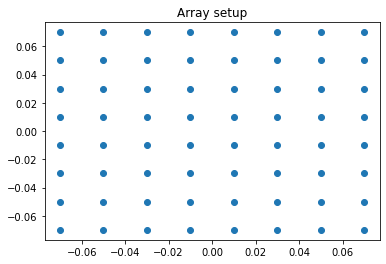

In [25]:
# set up arrays
array_matrices = antenna_setup()
sub_arrays = len(array_matrices)
print('Numer of active arrays: '+ str(sub_arrays))

In [26]:
# AUDIO SIGNALS
if config.audio_signals == 'emulated':
    filename = generate_filename()
    #filename = 'emul_100Hz_theta=0_phi=45_samples=300'
            # Create and place out sources
        # source1 and source2 below can be generated in parallell
    source1 = Audio_source(config.f_start1, config.f_end1, config.f_res1,
                        config.theta_deg1, config.phi_deg1, config.away_distance, 
                        config.t_start1, config.t_end1)
    source2 = Audio_source(config.f_start2, config.f_end2, config.f_res2,
                        config.theta_deg2, config.phi_deg2, config.away_distance, 
                        config.t_start2, config.t_end2)
    source_list = [source1, source2]
    sources = np.array(source_list[:config.sources])
    try:
        # array_audio_signals = np.load(filename)
        array_audio_signals = np.load('emulated_data/'+filename+'.npy', allow_pickle=True)
        print("Loading from Memory: " + filename)
    except:
        print("Creating data file:"+filename)

        
        # GENERATE AUDIO SIGNAL
        # will only be used to emulate data, this will not be used when the algoritm runs with real data
        array_audio_signals = np.zeros((sub_arrays), dtype=object)
        print('Number of samples generated (of '+str(f_sampling*t_total)+'):')
        for array in range(sub_arrays):  # PARALLELL
            # generate the audio signals on each array-element for each sub-array
            temp_signal = generate_array_signals(array_matrices[array], sources, t)
            array_audio_signals[array] = Audio_data(temp_signal)
            print('Audio signal for array '+str(array+1)+' generated')

        np.save('emulated_data/'+filename, array_audio_signals)

elif config.audio_signals == 'recorded':
    filename = config.filename
    print('Loading recorded data: '+filename)
    array_audio_signals = np.zeros((sub_arrays), dtype=object)
    array_audio_signals[0], f_sampling = load_data_FPGA(filename)
else:
    array_audio_signals = 0

Creating data file:emul_4000Hz_theta=40_phi=20_samples=300_A1
Number of samples generated (of 300.0):
1
100
200
300
Audio signal for array 1 generated


In [27]:
#original_signal = array_audio_signals[0].get_audio_signals()[:,7]
#scaled = original_signal/np.max(np.abs(original_signal))
#play_sound(scaled, f_sampling)

In [28]:
# BEAMFORMING values
x_res = config.x_res                # resolution in x
y_res = config.y_res                # resolution in y
x_listen = np.linspace(-1,1,x_res)  # scanning window, x coordinates
y_listen = np.linspace(-1,1,y_res)  # scanning window, y coordinates
r_scan = math.sqrt(2)               # radius of our scanning window, r_scan² = x²+y²+z²

In [29]:
# Filtering values
f_bands_N = config.f_bands_N         # number of frequency bands
bandwidth = [100, f_sampling/2-f_sampling/100]  # bandwidth of incoming audio signal
frequency_bands = np.linspace(bandwidth[0],bandwidth[1],f_bands_N) # vector holding center frequencies of all frequency bands
samples = len(array_audio_signals[0].get_audio_signals()[:,0])
#filter_coefficients = np.zeros((f_bands_N, filter_order+1)) # might only be used for plots

In [30]:
# load adaptive weights, calibration weights and filter coefficients
adaptive_weight_matrix = adaptive_array_config_matrix(array_matrices[0])
calibration_weights = load_calibration_weights(0,config.rows*config.columns, config.f_bands_N)
filter_coefficients = calculate_filter_coefficients(f_sampling, frequency_bands)

Filtering of signals completed.


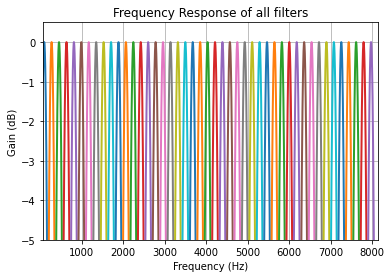

In [31]:
# FILTERING
audio_filtered_complete = filtering(array_audio_signals, sub_arrays, frequency_bands, f_sampling, array_matrices[0].get_elements())

In [32]:
# start scanning after sources, at all different angles, 
intensity_maps = scanning(y_listen, x_listen, r_scan, frequency_bands, audio_filtered_complete, array_matrices, f_sampling, sub_arrays)
#intensity_maps = scanning(array_audio_signals, array_matrices, x_listen, y_listen, r_scan, \
#    adaptive_weight_matrix, calibration_weights, filter_coefficients, frequency_bands, f_sampling, samples, sub_arrays)


 x_ind: 1
	 y_ind: 1 2 3 4 5 6 7 8 9 10 
 x_ind: 2
	 y_ind: 1 2 3 4 5 6 7 8 9 10 
 x_ind: 3
	 y_ind: 1 2 3 4 5 6 7 8 9 10 
 x_ind: 4
	 y_ind: 1 2 3 4 5 6 7 8 9 10 
 x_ind: 5
	 y_ind: 1 2 3 4 5 6 7 8 9 10 
 x_ind: 6
	 y_ind: 1 2 3 4 5 6 7 8 9 10 
 x_ind: 7
	 y_ind: 1 2 3 4 5 6 7 8 9 10 
 x_ind: 8
	 y_ind: 1 2 3 4 5 6 7 8 9 10 
 x_ind: 9
	 y_ind: 1 2 3 4 5 6 7 8 9 10 
 x_ind: 10
	 y_ind: 1 2 3 4 5 6 7 8 9 10 

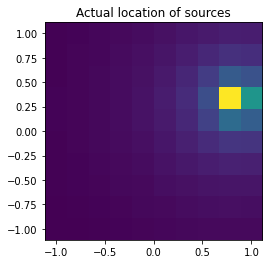

In [33]:
# Check where the source is actually located
source1 = Audio_source(config.f_start1, config.f_end1, config.f_res1,
                  config.theta_deg1, config.phi_deg1, config.away_distance, 
                  config.t_start1, config.t_end1)
source2 = Audio_source(config.f_start2, config.f_end2, config.f_res2,
                  config.theta_deg2, config.phi_deg2, config.away_distance, 
                  config.t_start2, config.t_end2)
source_list = [source1, source2]
sources = np.array(source_list[:config.sources])
if config.audio_signals == 'emulated':
   validation_check(y_listen, x_listen, sources, r_scan)

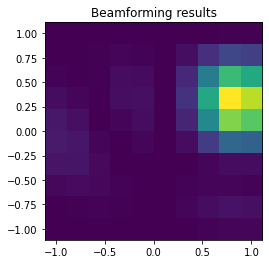

In [34]:
# show the beamforming results
total_intensity = show_beamforming_results(y_listen, x_listen, intensity_maps)

In [35]:
def show_colormap(filename):
    color_map = np.load('color_maps/'+filename+'.npy', allow_pickle=True)
    plt.figure(4)
    plt.imshow(color_map, extent= extents(x_listen) + extents(y_listen), origin='lower')
    plt.suptitle('Beamforming results')
    plt.title(filename)
    plt.savefig('color_maps_jpg/'+filename+'.jpg')


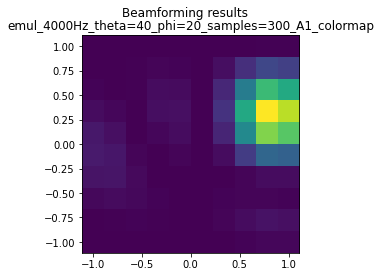

In [36]:

filename_colormap = filename +'_colormap'
np.save('color_maps/'+filename_colormap, total_intensity)
show_colormap(filename_colormap)

In [37]:
#show_colormap('emul_8000Hz_theta=40_phi=20_samples=500_colormap')

In [38]:
#audio = listening_improved(array_audio_signals, array_matrices, config.theta_listen, config.phi_listen, adaptive_weight_matrix, calibration_weight, filter_coefficients, frequency_bands, f_sampling, samples, sub_arrays)

In [39]:
#scaled_audio = original_signal/np.max(np.abs(audio2))
#play_sound(scaled_audio, f_sampling)